In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import avg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySparkShell, master=yarn) created by <module> at /opt/conda/anaconda/lib/python3.6/site-packages/IPython/utils/py3compat.py:188 

In [3]:
import os
import pickle
import requests
import json

In [4]:
input_dir = 'gs://data-stroke-1/'
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(input_dir+'stroke.csv')
df.columns

['gender',
 'age',
 'diabetes',
 'hypertension',
 'stroke',
 'heart disease',
 'smoking history',
 'BMI']

In [5]:
pd.DataFrame(df.take(5), columns=df.columns)

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,0.0,80.0,0,0,0,1,0.0,25.19
1,0.0,54.0,0,0,0,0,NaN,NaN
2,1.0,28.0,0,0,0,0,0.0,NaN
3,0.0,36.0,0,0,0,0,1.0,23.45
4,1.0,76.0,0,1,0,1,1.0,20.14


In [6]:
featureColumns = ['gender','age',
 'diabetes',
 'hypertension',
 'heart disease',
 'smoking history',
 'BMI']

In [7]:
df.printSchema()

root
 |-- gender: double (nullable = true)
 |-- age: double (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- heart disease: integer (nullable = true)
 |-- smoking history: double (nullable = true)
 |-- BMI: double (nullable = true)



In [8]:
df = df.filter(df.age >2)
df.count()

96713

## Print the Type of Classes Present

([<matplotlib.axis.XTick at 0x7fbf0b74ba58>,
 <a list of 2 Text xticklabel objects>)

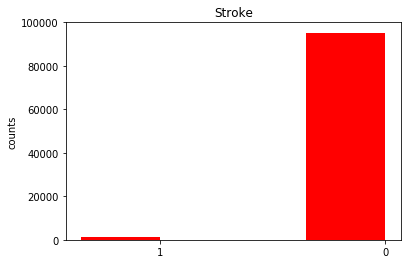

In [9]:
responses = df.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

## Missing Data Management

In [10]:
removeAllDF = df.na.drop()

In [11]:
removeAllDF.describe(['BMI']).show()

+-------+-----------------+
|summary|              BMI|
+-------+-----------------+
|  count|            51910|
|   mean|28.73434540550936|
| stddev|7.176299150987031|
|    min|            10.08|
|    max|            91.82|
+-------+-----------------+



In [12]:
removeAllDF.count()

51910

In [13]:
imputeDF = df
# imputeDF = imputeDF.drop('smoking history')

In [14]:
# for index,row in imputeDF.toPanda.iterrows():
#     print(row)
imputeDF_Pandas = imputeDF.toPandas()

In [15]:
# for x in imputeDF.columns:
#     meanValue = removeAllDF.agg(avg(x)).first()[0]
#     print(x, meanValue)
#     imputeDF = imputeDF.na.fill(meanValue, [x])
    
# for x in imputeDF.columns:
#     if x == 'BMI':
#         if imputeDF.age > 10:
#             imputeDF = imputeDF.BMI.fill(10, [x])
#         elif imputeDF.age > 10:
#             imputeDF = imputeDF.BMI.fill(22, [x])

df_2_9 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=2 ) & (imputeDF_Pandas['age'] <= 9)]
values = {'smoking history': 0, 'BMI':17.125}
df_2_9 = df_2_9.fillna(value = values)

df_10_13 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=10 ) & (imputeDF_Pandas['age'] <= 13)]
values = {'smoking history': 0, 'BMI':19.5}
df_10_13 = df_10_13.fillna(value = values)

df_14_17 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=14 ) & (imputeDF_Pandas['age'] <= 17)]
values = {'smoking history': 0, 'BMI':23.05}
df_14_17 = df_14_17.fillna(value = values)

df_18_24 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=18 ) & (imputeDF_Pandas['age'] <= 24)]
values = {'smoking history': 0, 'BMI':27.1}
df_18_24 = df_18_24.fillna(value = values)

df_25_29 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=25 ) & (imputeDF_Pandas['age'] <= 29)]
values = {'smoking history': 0, 'BMI':27.9}
df_25_29 = df_25_29.fillna(value = values)

df_30_34 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=30 ) & (imputeDF_Pandas['age'] <= 34)]
values = {'smoking history': 0.25, 'BMI':29.6}
df_30_34 = df_30_34.fillna(value = values)

df_35_44 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=35 ) & (imputeDF_Pandas['age'] <= 44)]
values = {'smoking history': 0.25, 'BMI':30.15}
df_35_44 = df_35_44.fillna(value = values)

df_45_49 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=45 ) & (imputeDF_Pandas['age'] <= 49)]
values = {'smoking history': 0, 'BMI':29.7}
df_45_49 = df_45_49.fillna(value = values)

df_50_59 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=50 ) & (imputeDF_Pandas['age'] <= 59)]
values = {'smoking history': 0, 'BMI':29.95}
df_50_59 = df_50_59.fillna(value = values)

df_60_74 = imputeDF_Pandas[(imputeDF_Pandas['age'] >=60 ) & (imputeDF_Pandas['age'] <= 74)]
values = {'smoking history': 0, 'BMI':30.1}
df_60_74 = df_60_74.fillna(value = values)

df_75_plus = imputeDF_Pandas[(imputeDF_Pandas['age'] >75 )]
values = {'smoking history': 0, 'BMI':28.1}
df_75_plus = df_75_plus.fillna(value = values)

In [16]:
all_frames = [df_2_9, df_10_13, df_14_17, df_18_24, df_25_29, df_30_34, df_35_44, df_45_49, df_50_59, df_60_74, df_75_plus]
df_combined = pd.concat(all_frames)

In [17]:
df_combined_converted = spark.createDataFrame(df_combined)
imputeDF = df_combined_converted

In [18]:
df.describe(['BMI']).show()
imputeDF.describe(['BMI']).show()

+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|             71655|
|   mean|27.731837834065807|
| stddev| 7.537126985853238|
|    min|             10.01|
|    max|             95.69|
+-------+------------------+

+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|             95992|
|   mean|27.835780273353016|
| stddev| 6.720075167959109|
|    min|             10.01|
|    max|             95.69|
+-------+------------------+



In [19]:
df.describe(['smoking history']).show()
imputeDF.describe(['smoking history']).show()

+-------+-------------------+
|summary|    smoking history|
+-------+-------------------+
|  count|              63873|
|   mean|  0.320941555899989|
| stddev|0.39194071654046597|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

+-------+-------------------+
|summary|    smoking history|
+-------+-------------------+
|  count|              95992|
|   mean|0.22577141845153761|
| stddev| 0.3490975672249249|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [20]:
type(imputeDF)
pd.DataFrame(imputeDF.take(5), columns=imputeDF.columns)

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,1.0,5.0,0,0,0,0,0.0,18.800
1,0.0,4.0,0,0,0,0,0.0,13.990
2,1.0,5.0,0,0,0,0,0.0,15.100
3,1.0,5.0,0,0,0,0,0.0,17.125
4,0.0,3.0,0,0,0,0,0.0,19.270


In [21]:
type(imputeDF)

pyspark.sql.dataframe.DataFrame

In [22]:
# A = {'A' : binarizedDF.gender, 'B' : binarizedDF.age, 'C' : binarizedDF.diabetes}
# B = {'A' : binarizedDF.stroke, 'B' : binarizedDF.label}


X = imputeDF.toPandas().filter(items=['gender', 'age', 'diabetes','hypertension','heart disease','smoking history','BMI'])
Y = imputeDF.toPandas().filter(items=['stroke'])

In [23]:
X.shape, Y.shape

((95992, 7), (95992, 1))

In [24]:
print('Class labels:', np.unique(Y))

Class labels: [0 1]


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [26]:
type(X_train)

pandas.core.frame.DataFrame

In [27]:
X_train.columns, Y_train.columns

(Index(['gender', 'age', 'diabetes', 'hypertension', 'heart disease',
        'smoking history', 'BMI'],
       dtype='object'), Index(['stroke'], dtype='object'))

## SMOTE - For Resampling the Minority Class

In [28]:
sm = SMOTE(random_state=12, ratio = 'auto', kind = 'regular')

In [29]:
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

print('Resampled dataset shape {}'.format(Counter(y_train_res)))

/opt/conda/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({0: 85150, 1: 85150})


In [30]:
# x_train_res

## Combining Resampled Data into One Spark Dataframe

In [31]:
# dataset = pd.DataFrame({'age':x_train_res[0], 'diabetes':x_train_res[1],'hypertension':x_train_res[2],'heart disease':x_train_res[3],'smoking history':x_train_res[4],'BMI':x_train_res[5]})
# print(dataset)
dataframe_1 = pd.DataFrame(x_train_res,columns=['gender', 'age', 'diabetes', 'hypertension', 'heart disease', 'smoking history', 'BMI'])
dataframe_2 = pd.DataFrame(y_train_res, columns = ['stroke'])

# frames = [dataframe_1, dataframe_2]
result = dataframe_1.combine_first(dataframe_2)

In [32]:
type(result)

pandas.core.frame.DataFrame

In [33]:
# result

In [34]:
imputeDF_1 = spark.createDataFrame(result)
testDF = spark.createDataFrame(result)

In [35]:
type(imputeDF_1)

pyspark.sql.dataframe.DataFrame

## Checking the Resampled Data

([<matplotlib.axis.XTick at 0x7fbf00af05f8>,
 <a list of 2 Text xticklabel objects>)

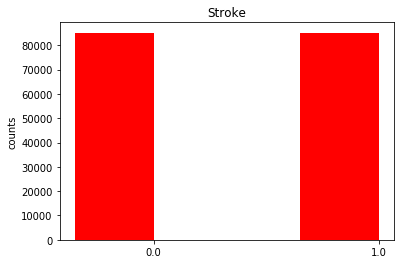

In [36]:
responses = imputeDF_1.groupBy('stroke').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

## Creating Assembler

In [37]:
binarizer = Binarizer(threshold=0.0, inputCol="stroke", outputCol="label")
binarizedDF = binarizer.transform(imputeDF_1)

In [38]:
binarizedDF.select("stroke", "label").show(4)

+------+-----+
|stroke|label|
+------+-----+
|   0.0|  0.0|
|   0.0|  0.0|
|   0.0|  0.0|
|   0.0|  0.0|
+------+-----+
only showing top 4 rows



In [39]:
binarizedDF = binarizedDF.drop('stroke')

In [40]:
binarizedDF.printSchema()

root
 |-- BMI: double (nullable = true)
 |-- age: double (nullable = true)
 |-- diabetes: double (nullable = true)
 |-- gender: double (nullable = true)
 |-- heart disease: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- smoking history: double (nullable = true)
 |-- label: double (nullable = true)



In [41]:
assembler = VectorAssembler(inputCols = featureColumns, outputCol = "features")
assembled = assembler.transform(binarizedDF)

In [42]:
print(assembled)

DataFrame[BMI: double, age: double, diabetes: double, gender: double, heart disease: double, hypertension: double, smoking history: double, label: double, features: vector]


# Splitting Data

In [43]:
(trainingData, testData) = assembled.randomSplit([0.7, 0.3], seed=13234)

In [44]:
trainingData.count(), testData.count()

(119224, 51076)

## Training

In [45]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

## Testing

In [46]:
predictions = model.transform(testData)

## AUC

In [47]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Aread under ROC score is : ", metrics.areaUnderROC)

Test Data Aread under ROC score is :  0.9810916421133257


## ROC

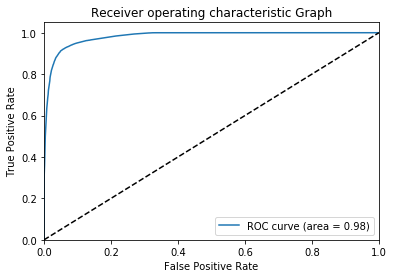

In [48]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()

In [49]:
## Distributions of Predictions

/opt/conda/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


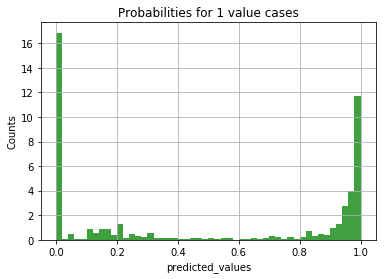

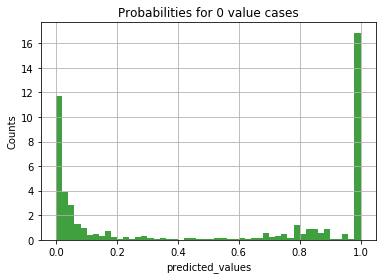

In [50]:
all_probs = predictions.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for 1 value cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for 0 value cases')
plt.grid(True)
plt.show()

In [51]:
# predictions.select("prediction", "label", 'rawPrediction', 'probability').show(10)

In [52]:
# evaluator = BinaryClassificationEvaluator()
# print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [53]:
# predictions.select("prediction", "label").write.save(path="file:///home/cloudera/Downloads/big-data-4/predict_100k_dt.csv",
#                                                     format="com.databricks.spark.csv",
#                                                     header = 'true')

In [54]:
# Saving model to disk
# out_dir = 'gs://data-stroke/result/'
# path = input_dir+'model'
# model.save(path)

In [55]:
# serialized_model = model.stages[0]._call_java('toDebugString')# Select example rows to display.
# predictions.select("prediction", "indexedLabel", "features").show(5)

In [56]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9319000463687693


In [57]:
# Select (prediction, true label) and compute test error
# evaluator = MulticlassClassificationEvaluator(
#     labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[0]
# summary only
print(treeModel)

Test Area Under ROC: 0.9319000463687693
0.9319000463687694
Test Error = 0.0681 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_daef1f11a307) of depth 17 with 837 nodes


In [61]:
# pd.DataFrame(testData.take(5), columns=testData.columns).transpose()
testData_1 = testData
testData_1 = testData_1.drop('gender','age','diabetes','hypertension','heart disease','smoking history','BMI')
testData_1 = testData_1.toPandas()

In [62]:
testData_1.loc[testData_1['label'] == 1]

,label,features
18,1.0,"[0.0, 79.0, 0.0, 0.0, 1.0, 1.0, 13.09]"
19,1.0,"[0.015105942171135145, 79.01510594217113, 0.0,..."
24,1.0,"[0.04232542611935419, 79.04232542611935, 0.0, ..."
28,1.0,"[0.1301288902457941, 79.1301288902458, 0.0, 0...."
32,1.0,"[0.0, 79.06143731388894, 0.06143731388894791, ..."
35,1.0,"[0.0, 79.08104546036333, 0.08104546036332594, ..."
41,1.0,"[0.3044429993694, 79.3044429993694, 0.0, 0.0, ..."
42,1.0,"[0.3066192600669786, 79.30661926006698, 0.0, 0..."
44,1.0,"[0.3508522579467478, 79.35085225794674, 0.0, 0..."
49,1.0,"[0.40592485791757416, 79.40592485791757, 0.0, ..."


In [58]:
# from pyspark.ml.feature import VectorIndexer

# indexer = VectorIndexer(inputCol="featureColumns", outputCol="indexed", maxCategories=10)
# indexerModel = indexer.fit(binarizedDF)

In [59]:
# categoricalFeatures = indexerModel.categoryMaps
# print("Chose %d categorical features: %s" %
#       (len(categoricalFeatures), ", ".join(str(k) for k in categoricalFeatures.keys())))


In [60]:
# indexedData = indexerModel.transform(trainingData)
# indexedData_1 = indexedData.drop("features")
# indexedData_1.show()

In [61]:
# df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(input_dir+'stroke_100K_1.csv')

# classifier = DecisionTreeClassifier(labelCol="label", featuresCol="indexed", maxDepth=25, minInstancesPerNode=30, impurity="gini")
# pipeline = Pipeline(stages = [classifier])
# pipelineModel = pipeline.fit(indexedData_1)

In [62]:
# from pyspark2pmml import PMMLBuilder

# pmmlBuilder = PMMLBuilder(sc, df, pipelineModel) \
# 	.putOption(classifier, "compact", True)

# pmmlBuilder.buildFile("DecisionTree.pmml")

In [58]:
print(trainingData)

DataFrame[BMI: double, age: double, diabetes: double, gender: double, heart disease: double, hypertension: double, smoking history: double, label: double, features: vector]


In [59]:
trainingData = trainingData.drop("features")

In [60]:
print(trainingData)

DataFrame[BMI: double, age: double, diabetes: double, gender: double, heart disease: double, hypertension: double, smoking history: double, label: double]


In [62]:
from pyspark.ml.feature import RFormula

formula = RFormula(formula = "label ~ .")
classifier = DecisionTreeClassifier(maxDepth=25, minInstancesPerNode=30, impurity="gini")
pipeline = Pipeline(stages = [formula, classifier])
pipelineModel = pipeline.fit(trainingData)

In [63]:
from pyspark2pmml import PMMLBuilder

pmmlBuilder = PMMLBuilder(sc, trainingData, pipelineModel) \
	.putOption(classifier, "compact", True)

pmmlBuilder.buildFile("dt-stroke.pmml")

'/home/yashwanthmadaka_imp24/dt-stroke.pmml'